In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sea
import matplotlib.pylab as plb

In [2]:
def id_outlier(out):
    test = np.zeros(out.shape[0])
    for i, x in enumerate(out['RESIDENTIAL_UNITS']):
        if (x > 35): test[i] = 1
    for i, x in enumerate(out['COMMERCIAL_UNITS']):
        if (x > 15): test[i] = 1
    for i, x in enumerate(out['YEAR_BUILT']):
        if (x < 1890): test[i] = 1
    for i, x in enumerate(out['SALE_PRICE']):
        if (x < 25000): test[i] = 1
    for i, x in enumerate(out['SALE_PRICE']):
        if (x > 3900000): test[i]=1
    for i, x in enumerate(out['LAND_SQUARE_FEET']):
        if (x > 9300): test[i]=1
    for i, x in enumerate(out['LAND_SQUARE_FEET']):
        if (x < 1950): test[i]=1
    for i, x in enumerate(out['GROSS_SQUARE_FEET']):
        if (x > 200000): test[i]=1
    for i, x in enumerate(out['GROSS_SQUARE_FEET']):
        if (x <= 3000): test[i]=1


    out['outlier'] = test 
    return out

In [3]:
def clean_mahatten(fileName = 'Manhattan12.csv'):

    manhatten= pd.read_csv(fileName)
    #Resets the Header to the column headings
    new_header = manhatten.iloc[3] 
    manhatten = manhatten[4:] 
    manhatten.columns = new_header
    manhatten.head()

    
    # new data frame with split value columns 
    new = manhatten["BUILDING CLASS CATEGORY"].str.split(" ", n = 2, expand = True) 
    # making separate building class id column from new data frame 
    manhatten["BUILDING_CLASS_ID"]= new[0] 
    # making separate building class type column from new data frame 
    manhatten["BUILDING_CLASS_TYPE"]= new[2] 
    
    #renaming columns
    manhatten. rename(columns={'SALE\nPRICE': 'SALE_PRICE', 'YEAR BUILT':'YEAR_BUILT',
                               'SALE DATE':'SALE_DATE', 'GROSS SQUARE FEET': 'GROSS_SQUARE_FEET',
                               'LAND SQUARE FEET': 'LAND_SQUARE_FEET', 'ZIP CODE':'ZIP_CODE',
                               'RESIDENTIAL UNITS': 'RESIDENTIAL_UNITS','COMMERCIAL UNITS':'COMMERCIAL_UNITS',
                               'TOTAL UNITS':'TOTAL_UNITS', 'TAX CLASS AT PRESENT': 'TAX_CLASS_PRESENT',
                               'BUILDING CLASS AT PRESENT': 'BUILDING_CLASS_PRESENT', 'TAX CLASS AT TIME OF SALE':
                               'TAX_CLASS_SALE','BUILDING CLASS AT TIME OF SALE': 'BUILDING_CLASS_SALE'
                               
                              }, inplace=True)
    
   
    #Dropping unwanted columns
    manhatten.drop(columns =["BUILDING CLASS CATEGORY", "APART\nMENT\nNUMBER", "BOROUGH", "EASE-MENT"], inplace = True) 
    
    #Cleans the '$' and ',' from the Numeric values
    manhatten['SALE_PRICE'] = manhatten['SALE_PRICE'].str.replace('$', '')
    manhatten['SALE_PRICE'] = manhatten['SALE_PRICE'].str.replace(',', '')
    manhatten['LAND_SQUARE_FEET'] = manhatten['LAND_SQUARE_FEET'].str.replace(',', '')
    manhatten['GROSS_SQUARE_FEET'] = manhatten['GROSS_SQUARE_FEET'].str.replace(',', '')

    
    #Converts some columns into numeric values, throws error if not
    cols = ['BUILDING_CLASS_ID', 'ZIP_CODE', 'TAX_CLASS_SALE',
                    'YEAR_BUILT','SALE_PRICE','BLOCK','LOT','RESIDENTIAL_UNITS','COMMERCIAL_UNITS',\
                    'TOTAL_UNITS','LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
    manhatten[cols] = manhatten[cols].apply(pd.to_numeric, errors='coerce')
    
    c_var = manhatten.select_dtypes(include=[np.object]).copy()
    n_var = manhatten.select_dtypes(include=[np.number])
    # prints out the 2 different lists
    print(c_var.dtypes)
    print(n_var.dtypes)
    
    #converts sale date to datetime
    manhatten['SALE_DATE'] = pd.to_datetime(manhatten['SALE_DATE'])
    
    # dropping ALL duplicte values 
    manhatten.drop_duplicates(  keep = False, inplace = True)
    
    pd.isnull(manhatten).sum()
    
    pd.isnull(manhatten).values.sum()
    
    #replaces 0 values for YEAR BUILT to NaN
    manhatten['YEAR_BUILT'].replace( 0, np.nan,inplace=True )
    
   
    
    #replaces 0s with the average from the Neigborhood and Building Class Type
    manhatten['LAND_SQUARE_FEET'] = manhatten['LAND_SQUARE_FEET'].replace(0, np.nan)
    manhatten['LAND_SQUARE_FEET']= manhatten['LAND_SQUARE_FEET'].fillna(manhatten.groupby(['NEIGHBORHOOD','BUILDING_CLASS_TYPE'])['LAND_SQUARE_FEET'].transform('mean'))
    manhatten['GROSS_SQUARE_FEET'] = manhatten['GROSS_SQUARE_FEET'].replace(0, np.nan)
    manhatten['GROSS_SQUARE_FEET']= manhatten['GROSS_SQUARE_FEET'].fillna(manhatten.groupby(['NEIGHBORHOOD','BUILDING_CLASS_TYPE'])['GROSS_SQUARE_FEET'].transform('mean'))
    
    #Removes spaces and replaces with NaN 
    c_var.replace(r'^\s+$', np.nan, regex=True)
    
    ## Checking for missing values
    pd.isnull(manhatten).values.sum()
    ## Remove rows with missing values in all columns
    manhatten.dropna(axis = 0, how = 'any', inplace = True)
  
    
    ## Removing outliers
    manhatten = id_outlier(manhatten) # mark outliers
    manhatten =  manhatten[ manhatten.outlier == 0] # filter for outliers
    manhatten.drop('outlier', axis = 1, inplace = True)
    
    
    manhatten.to_csv('cleaned_manhatten_data.csv')
    return manhatten

In [4]:
man = pd.read_csv('Manhattan12.csv')
man.describe()

,Manhattan Rolling Sales File. All Sales From August 2012 - August 2013.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
count,27399,27396,27396,27396,27396,27396,27396,27396,27396,27396,...,27396,27396,27396,27396,27396,27396,27396,27396,27396,27396
unique,5,41,34,10,1422,1792,2,122,13861,2995,...,122,53,133,1285,1884,136,4,121,5294,354
top,1,MIDTOWN WEST,13 CONDOS - ELEVATOR APARTMENTS,2,1027,37,,R4,870 7 AVENUE,,...,0,0,1,0,0,0,2,R4,$0,17/12/2012
freq,27395,6264,8480,18394,2710,1849,27395,8384,2087,14570,...,16372,23962,13772,22906,23069,6441,19926,8480,7593,485


In [5]:
man_cln = clean_mahatten()
man_cln.head(50)



<ipython-input-3-7efc43cae82d>:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  manhatten['SALE_PRICE'] = manhatten['SALE_PRICE'].str.replace('$', '')
<ipython-input-3-7efc43cae82d>:46: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c_var = manhatten.select_dtypes(include=[np.object]).copy()


3
NEIGHBORHOOD              object
TAX_CLASS_PRESENT         object
BUILDING_CLASS_PRESENT    object
ADDRESS                   object
BUILDING_CLASS_SALE       object
SALE_DATE                 object
BUILDING_CLASS_TYPE       object
dtype: object
3
BLOCK                  int64
LOT                    int64
ZIP_CODE               int64
RESIDENTIAL_UNITS    float64
COMMERCIAL_UNITS       int64
TOTAL_UNITS          float64
LAND_SQUARE_FEET       int64
GROSS_SQUARE_FEET      int64
YEAR_BUILT             int64
TAX_CLASS_SALE         int64
SALE_PRICE             int64
BUILDING_CLASS_ID    float64
dtype: object


3,NEIGHBORHOOD,TAX_CLASS_PRESENT,BLOCK,LOT,BUILDING_CLASS_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_SALE,BUILDING_CLASS_SALE,SALE_PRICE,SALE_DATE,BUILDING_CLASS_ID,BUILDING_CLASS_TYPE
22,ALPHABET CITY,1,377,66,C0,243 EAST 7TH STREET,10009,3.0,0,3.0,2381.0,3084.0,1899.0,1,C0,3150000,2013-06-03,3.0,THREE FAMILY HOMES
25,ALPHABET CITY,2,375,62,C4,715 EAST 5TH STREET,10009,20.0,0,20.0,2426.0,9345.0,1900.0,2,C4,3650000,2012-06-09,7.0,RENTALS - WALKUP APARTMENTS
26,ALPHABET CITY,2,376,30,C4,274 EAST SEVENTH STREET,10009,13.0,0,13.0,2726.0,13002.0,1910.0,2,C4,895250,2012-10-25,7.0,RENTALS - WALKUP APARTMENTS
29,ALPHABET CITY,2,391,55,C4,309 EAST 8TH STREET,10009,17.0,0,17.0,2164.0,9071.0,1900.0,2,C4,3500000,2012-10-16,7.0,RENTALS - WALKUP APARTMENTS
146,ALPHABET CITY,2A,393,4,S4,165 AVENUE B,10009,4.0,1,5.0,2201.0,5608.0,1900.0,2,S4,3800000,2012-04-12,14.0,RENTALS - 4-10 UNIT
166,ALPHABET CITY,4,387,34,M1,67 AVENUE C,10009,0.0,1,1.0,2160.0,3050.0,1951.0,4,M1,2400000,2013-07-18,37.0,RELIGIOUS FACILITIES
169,ALPHABET CITY,4,392,4,M1,149 AVENUE B,10009,2.0,1,3.0,2139.0,6440.0,1900.0,4,M1,3200000,2012-09-27,37.0,RELIGIOUS FACILITIES
221,CHELSEA,2A,722,11,C2,449 WEST 24TH STREET,10011,5.0,0,5.0,2057.0,4072.0,1900.0,2,C2,3900000,2012-04-12,7.0,RENTALS - WALKUP APARTMENTS
249,CHELSEA,2,800,20,D6,135 WEST 24TH STREET,10011,23.0,1,24.0,2925.0,12609.0,1901.0,2,D6,1911390,2012-05-10,8.0,RENTALS - ELEVATOR APARTMENTS
250,CHELSEA,2,801,49,D5,110 WEST 26TH STREET,10001,11.0,2,13.0,4090.0,26027.0,1907.0,2,D5,2176160,2012-12-21,8.0,RENTALS - ELEVATOR APARTMENTS


In [6]:
man_cln['LPRICE'] = np.log(man_cln.SALE_PRICE)


In [7]:
man_cln.shape

(1006, 20)

In [8]:
man_cln.describe()

3,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_SALE,SALE_PRICE,BUILDING_CLASS_ID,LPRICE
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03,1006.000000,1006.000000
mean,1129.818091,39.387674,10022.398608,3.404573,1.411531,4.816103,5954.371769,72583.336978,1968.615308,3.255467,7.825450e+05,18.864811,12.352812
std,474.317239,41.625107,30.065818,7.604027,1.164836,7.255602,2104.777998,48919.793432,47.097973,0.990173,1.125313e+06,8.385347,1.585353
min,132.000000,1.000000,10001.000000,0.000000,0.000000,0.000000,1950.000000,3050.000000,1890.000000,1.000000,2.750000e+04,1.000000,10.221941
25%,1009.000000,37.000000,10019.000000,0.000000,0.000000,2.000000,3974.000000,13668.333333,1915.000000,2.000000,5.889325e+04,9.000000,10.983482
50%,1009.000000,37.000000,10019.000000,0.000000,2.000000,2.000000,7532.000000,112850.000000,2007.000000,4.000000,1.124315e+05,25.000000,11.630099
75%,1009.000000,37.000000,10019.000000,0.000000,2.000000,2.000000,7532.000000,112850.000000,2007.000000,4.000000,1.260000e+06,25.000000,14.046622
max,2238.000000,546.000000,10463.000000,35.000000,13.000000,35.000000,8513.000000,112850.000000,2009.000000,4.000000,3.900000e+06,41.000000,15.176487


In [9]:
man_cln.dtypes

3
NEIGHBORHOOD                      object
TAX_CLASS_PRESENT                 object
BLOCK                              int64
LOT                                int64
BUILDING_CLASS_PRESENT            object
ADDRESS                           object
ZIP_CODE                           int64
RESIDENTIAL_UNITS                float64
COMMERCIAL_UNITS                   int64
TOTAL_UNITS                      float64
LAND_SQUARE_FEET                 float64
GROSS_SQUARE_FEET                float64
YEAR_BUILT                       float64
TAX_CLASS_SALE                     int64
BUILDING_CLASS_SALE               object
SALE_PRICE                         int64
SALE_DATE                 datetime64[ns]
BUILDING_CLASS_ID                float64
BUILDING_CLASS_TYPE               object
LPRICE                           float64
dtype: object

No handles with labels found to put in legend.


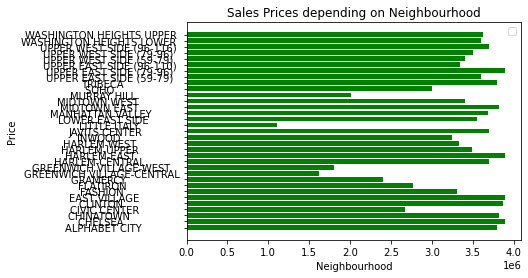

In [10]:
neigh = man_cln["NEIGHBORHOOD"]

price = man_cln['SALE_PRICE']

plt.barh(neigh, price, color='g')
plt.rcParams['figure.figsize'] = 70,100
plt.xlabel('Neighbourhood')
plt.ylabel('Price')
plt.title('Sales Prices depending on Neighbourhood')
plt.legend()
plt.show()

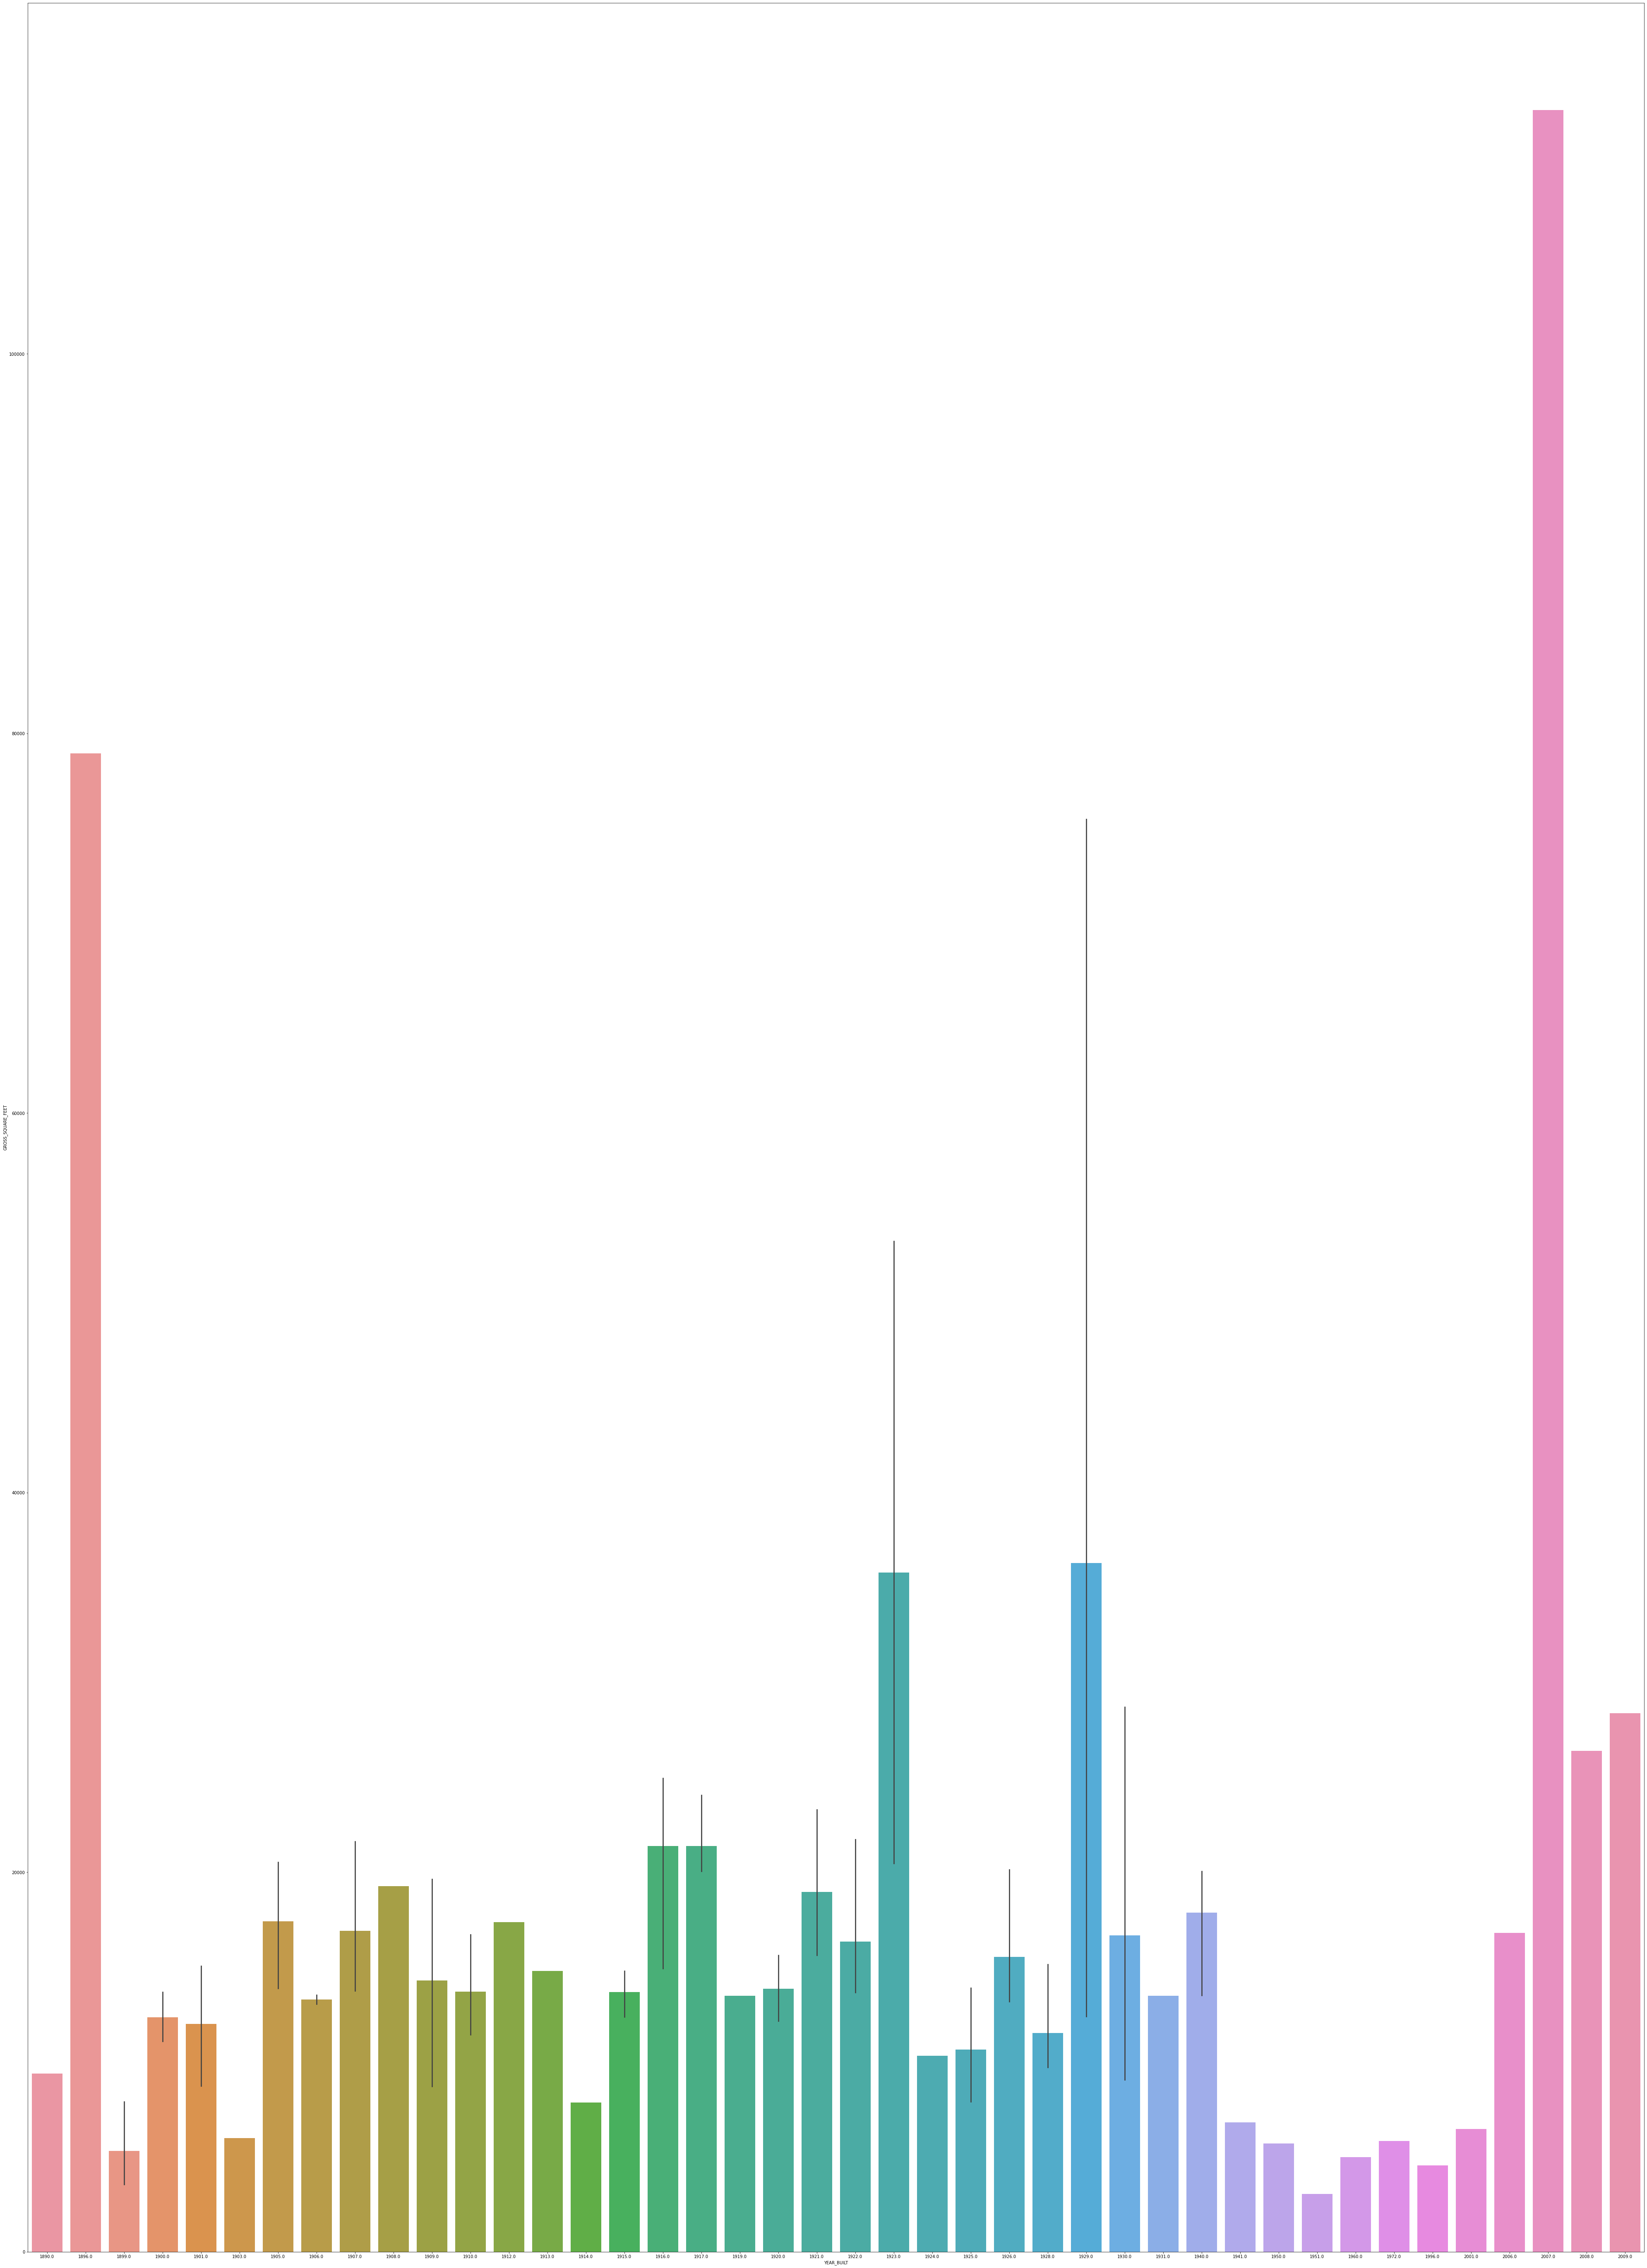

In [11]:
x = sea.barplot(x="YEAR_BUILT", y="GROSS_SQUARE_FEET", data=man_cln)


<ipython-input-12-6e69aaa35b5d>:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  scatter_matrix(man[cols], alpha=0.3, diagonal='hist', ax = ax)


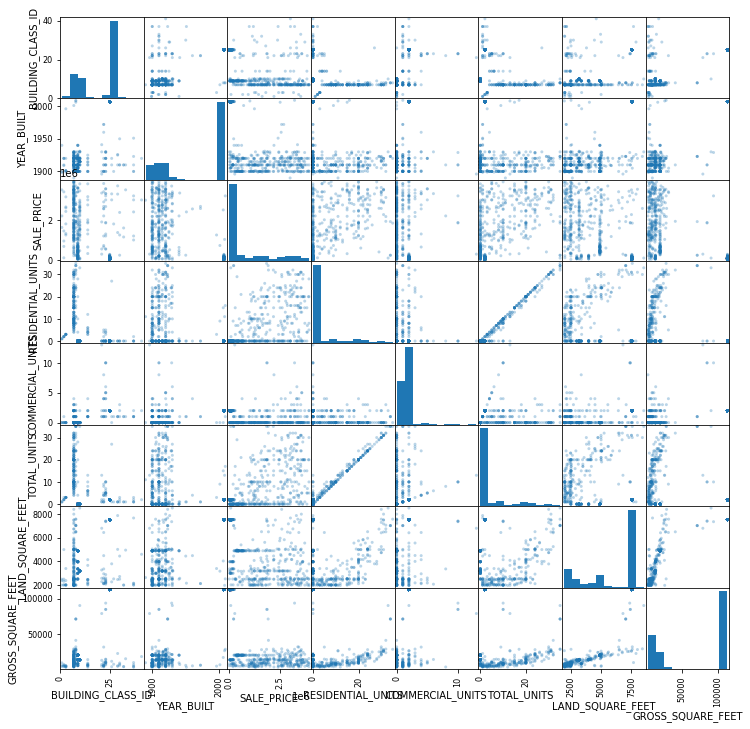

'Done'

In [12]:
cols = ['BUILDING_CLASS_ID','YEAR_BUILT','SALE_PRICE','RESIDENTIAL_UNITS','COMMERCIAL_UNITS',
                    'TOTAL_UNITS','LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']

def man_scat(cols, man):
    from pandas.plotting import scatter_matrix
    fig = plt.figure(1, figsize=(12, 12))
    fig.clf()
    ax = fig.gca()
    scatter_matrix(man[cols], alpha=0.3, diagonal='hist', ax = ax)
    plt.show()
    return('Done')
man_scat(cols, man_cln)

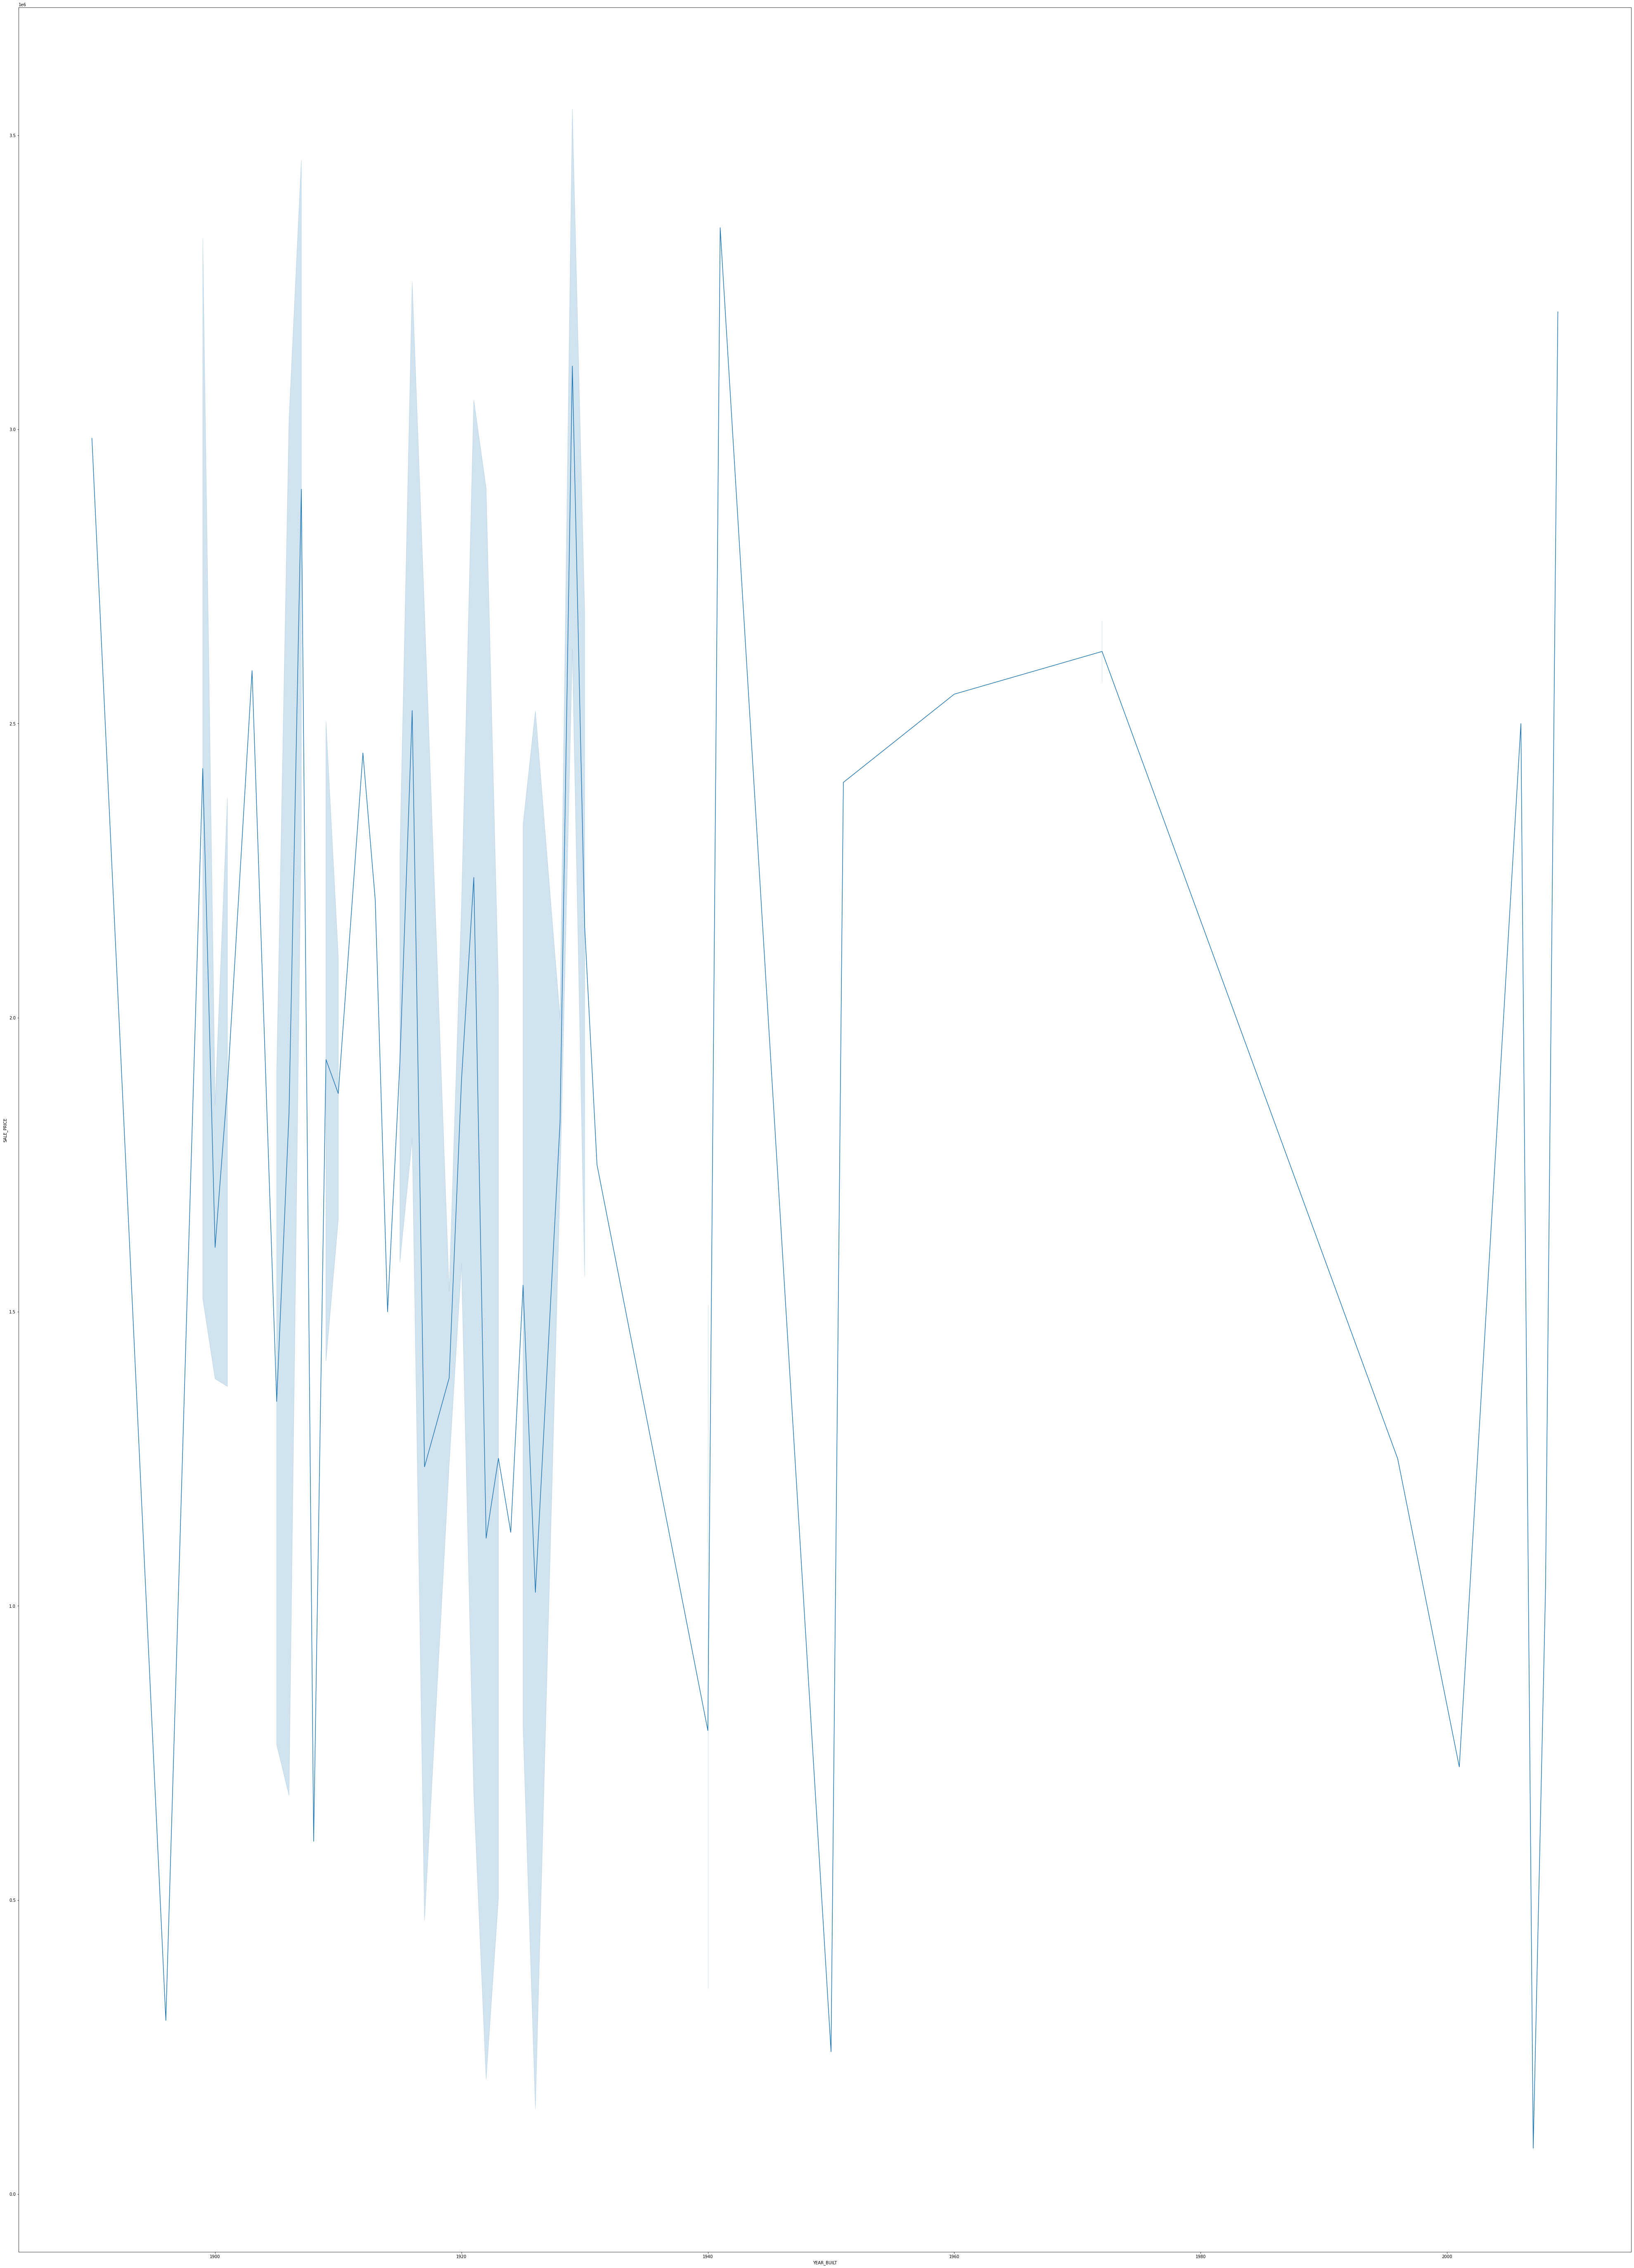

In [13]:
ax = sea.lineplot(x="YEAR_BUILT", y="SALE_PRICE", data=man_cln)

In [14]:
def normalize(man):
#select numerical columns
    num_col = man.select_dtypes(include=[np.number]).copy()
    num_col.drop('SALE_PRICE', axis='columns', inplace=True)
    man_norm = ((num_col-num_col.min())/(num_col.max()-num_col.min()))
    
    return man_norm
man_norm = normalize(man_cln)
man_norm.describe()

3,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_SALE,BUILDING_CLASS_ID,LPRICE
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000
mean,0.473798,0.070436,0.046317,0.097274,0.108579,0.137603,0.610143,0.633273,0.660633,0.751822,0.446620,0.430084
std,0.225222,0.076376,0.065078,0.217258,0.089603,0.207303,0.320704,0.445535,0.395781,0.330058,0.209634,0.319980
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.416429,0.066055,0.038961,0.000000,0.000000,0.057143,0.308396,0.096706,0.210084,0.333333,0.200000,0.153705
50%,0.416429,0.066055,0.038961,0.000000,0.153846,0.057143,0.850526,1.000000,0.983193,1.000000,0.600000,0.284215
75%,0.416429,0.066055,0.038961,0.000000,0.153846,0.057143,0.850526,1.000000,0.983193,1.000000,0.600000,0.771954
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


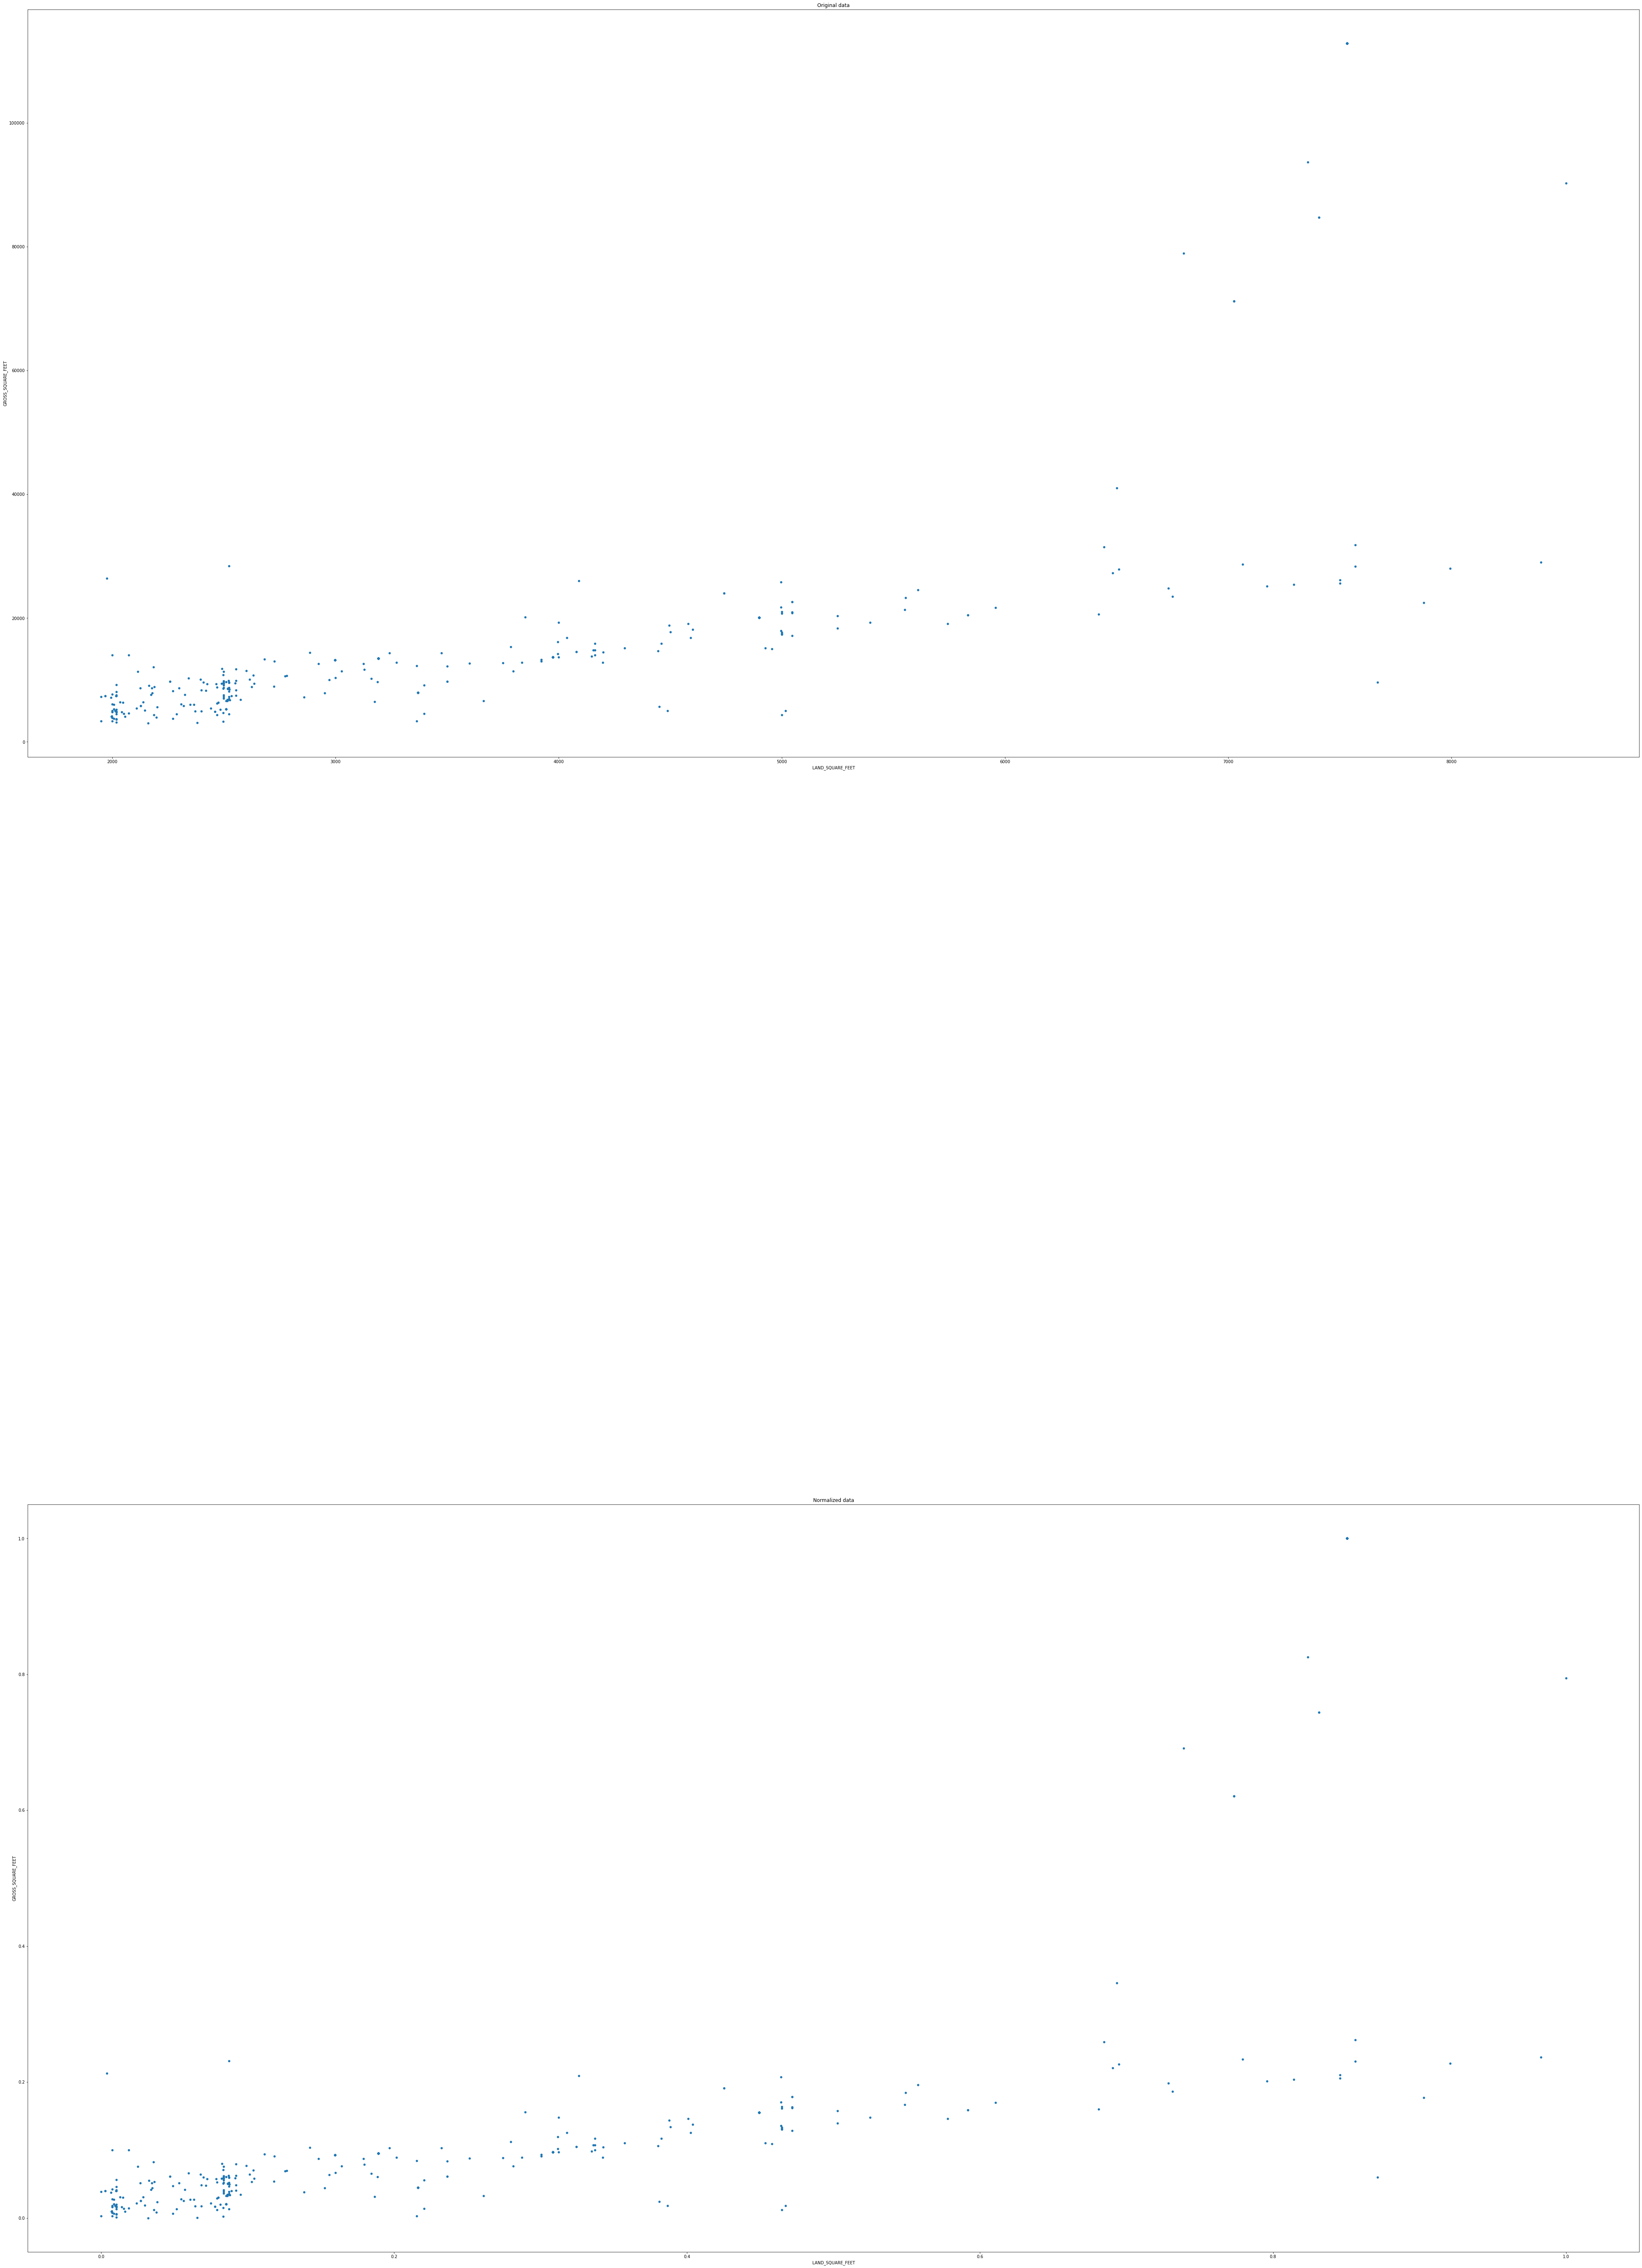

In [15]:
f, ax = plt.subplots(2)
man_cln.plot.scatter(  x="LAND_SQUARE_FEET", y="GROSS_SQUARE_FEET",ax=ax[0], title="Original data")
man_norm.plot.scatter( x="LAND_SQUARE_FEET", y="GROSS_SQUARE_FEET", ax=ax[1], title="Normalized data")
f.subplots_adjust(hspace=1)
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
man_train, man_test = train_test_split(man_norm, test_size=0.3)
print("Training size: {}, Testing size: {}".format(len(man_train), len(man_test)))
print("Samples: {} Features: {}".format(*man_train.shape))

Training size: 704, Testing size: 302
Samples: 704 Features: 12


In [27]:
from sklearn import svm, feature_selection, linear_model
fman = man_norm.select_dtypes(include=[np.number]).copy()
feature_cols = fman.columns.values.tolist()
feature_cols.remove('LPRICE')
XO = fman[feature_cols]
YO = fman['LPRICE']
estimator = svm.SVR(kernel="linear")
selector = feature_selection.RFE(estimator, 5, step=1)
selector = selector.fit(XO, YO)

select_features = np.array(feature_cols)[selector.ranking_ == 1].tolist()
print(select_features)

['BLOCK', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET']


/Users/danking/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [18]:
X = fman[select_features]
Y = fman['LPRICE']
trX, testX, trY, testY = train_test_split(X, Y, test_size=0.2)
lm = linear_model.LinearRegression()
lm.fit(trX, trY)
# Inspect the calculated model equations
print("Y-axis intercept {:6.4f}".format(lm.intercept_))
print("Weight coefficients:")
for feat, coef in zip(select_features, lm.coef_):
    print(" {:>20}: {:6.4f}".format(feat, coef))
# The value of R^2
print("R squared for the training data is {:4.3f}".format(lm.score(trX, trY)))
print("Score against test data: {:4.3f}".format(lm.score(testX, testY)))

Y-axis intercept 0.8090
Weight coefficients:
                BLOCK: -0.2191
    RESIDENTIAL_UNITS: 0.1696
     COMMERCIAL_UNITS: 0.4533
          TOTAL_UNITS: 0.3379
    GROSS_SQUARE_FEET: -0.6120
R squared for the training data is 0.847
Score against test data: 0.882


In [19]:
def mse(fman, pred, obs):
    q = fman.shape[0]
    return sum((fman[pred]-fman[obs])**2)/q
fman['pred'] = lm.predict(X)
print("Mean Squared error: {}".format(mse(fman,'pred', 'LPRICE')))

Mean Squared error: 0.014858996678932493


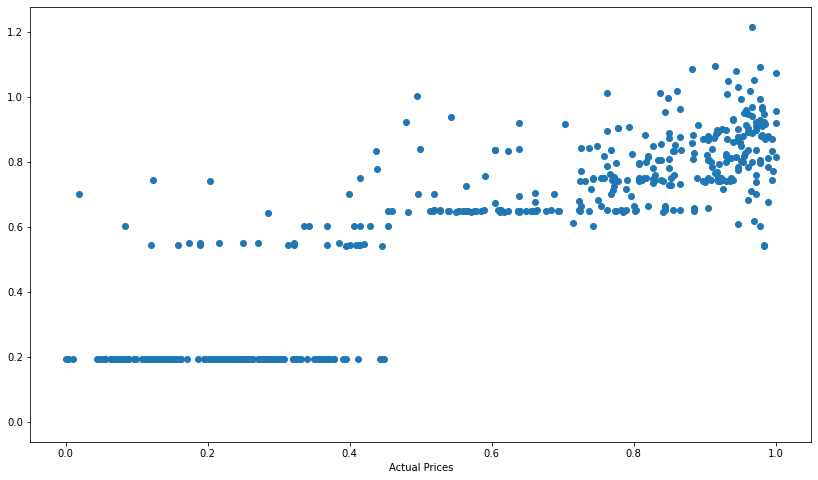

In [20]:
pred_trainY = lm.predict(trX)
plt.figure(figsize=(14, 8))
# ax = fig.add_subplot(111)
plt.plot(trY, pred_trainY, 'o')
plt.plot(range(int(man_norm['LPRICE'].max())),range(int(man_norm['LPRICE'].max())), color='red')
plb.xlabel('Actual Prices')
plt.ylabel="Predicted Prices"
plt.title="Plot of predicted vs actual prices"
plt.show()

0.8871580801741292


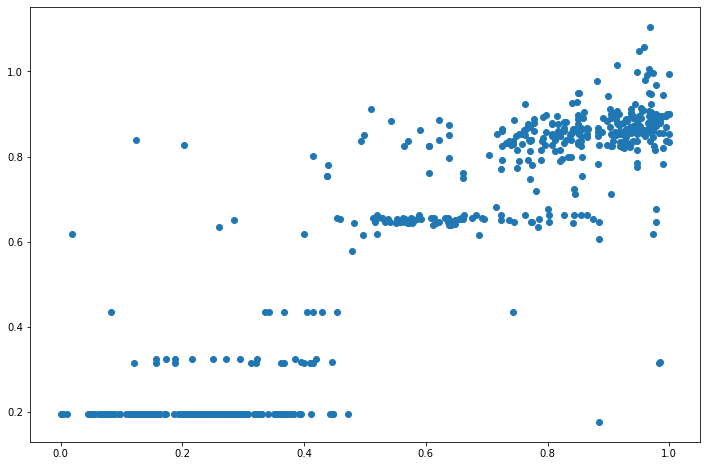

In [21]:
rb = svm.SVR(kernel="rbf", C=1e2, tol=1e-4)
rb.fit(trX, trY)
print(rb.score(testX, testY))
predicted = rb.predict(man_norm[select_features])
plt.figure(figsize=(12, 8))
plt.scatter(man_norm['LPRICE'], predicted)
plt.xlabel = "Actual Prices"
plt.ylabel = "Predicted Prices"
plt.title="Plot of the predicted vs the actual price"
plt.show()

In [22]:
model = smf.ols(formula='LPRICE ~ TOTAL_UNITS + YEAR_BUILT', data = man_norm).fit()
print(model.params)
print('R squared is: ', model.rsquared)
model.summary()

Intercept      0.790429
TOTAL_UNITS    0.354463
YEAR_BUILT    -0.619286
dtype: float64
R squared is:  0.7972731886771228


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LPRICE   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     1972.
Date:                Sun, 22 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:02:48   Log-Likelihood:                 522.12
No. Observations:                1006   AIC:                            -1038.
Df Residuals:                    1003   BIC:                            -1023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7904      0.011     69.321      0.000       0.768       0.813
TOTAL_UNITS     0.3545      0.025     14.437      0.000       0.306       0.403
YEAR_BUILT     -0.6193      0.013    -48.156      0.000      -0.645      -0.594
==============================================================================
Omnibus:                       97.014   Durbin-Watson:                   1.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              465.263
Skew:                          -0.297   Prob(JB):                    9.32e-102
Kurtosis:                       6.278   Cond. No.                         7.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TypeError: 'str' object is not callable

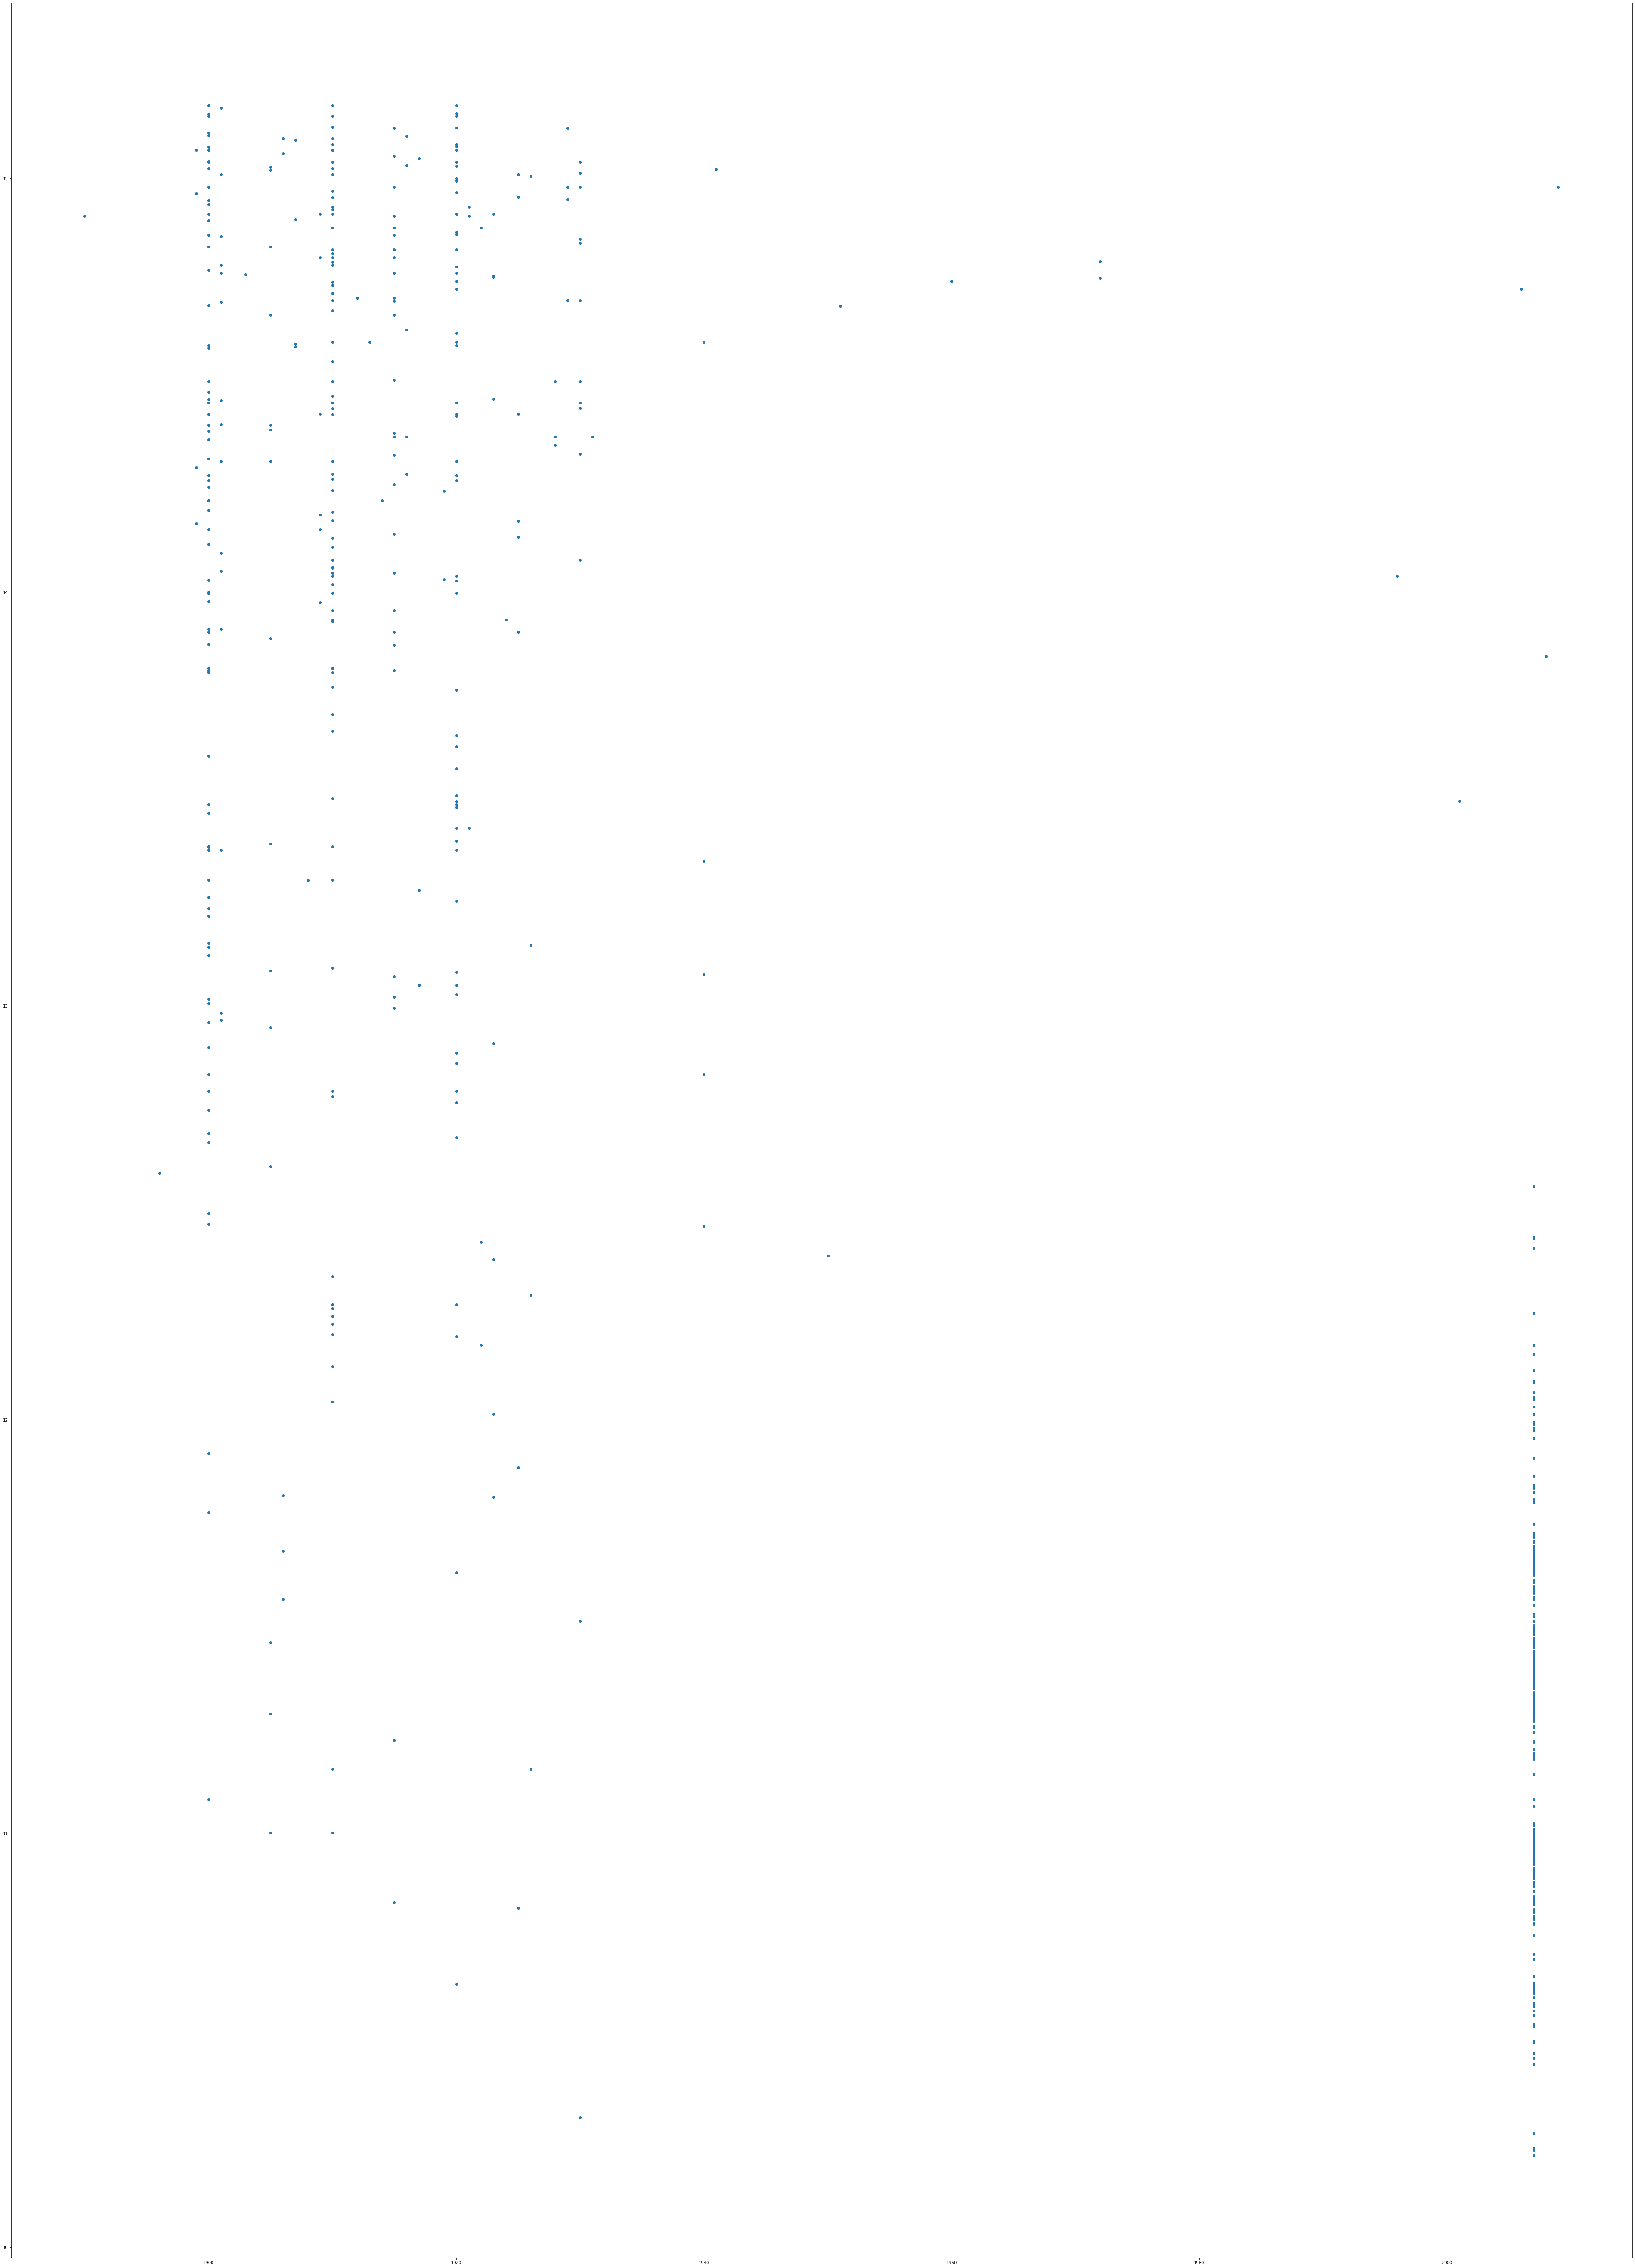

<Figure size 3600x1440 with 0 Axes>

In [23]:
y = man_cln ['LPRICE']
x1 = man_cln ['YEAR_BUILT']
plt.scatter(x1,y)
plt.figure(figsize=(50, 20))
plt.ylabel('SALE_PRICE', fontsize = 20)
plt.xlabel('YEAR_BUILT', fontsize = 20)
# Show the plot
plt.show()

In [24]:
x = sm.add_constant(x1)
# Fit the model, according to the OLS (ordinary least squares) method with a dependent variable y and an idependent x
results = sm.OLS(y,x).fit()
# Print a nice summary of the regression. That's one of the strong points of statsmodels -> the summaries
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LPRICE   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     3096.
Date:                Sun, 22 Jan 2023   Prob (F-statistic):          4.93e-309
Time:                        20:03:20   Log-Likelihood:                -1182.8
No. Observations:                1006   AIC:                             2370.
Df Residuals:                    1004   BIC:                             2379.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.9366      1.035     67.563      0.000      67.905      71.968
YEAR_BUILT    -0.0293      0.001    -55.645      0.000      -0.030      -0.028
==============================================================================
Omnibus:                      119.829   Durbin-Watson:                   1.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              459.367
Skew:                          -0.515   Prob(JB):                    1.78e-100
Kurtosis:                       6.146   Cond. No.                     8.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

TypeError: 'str' object is not callable

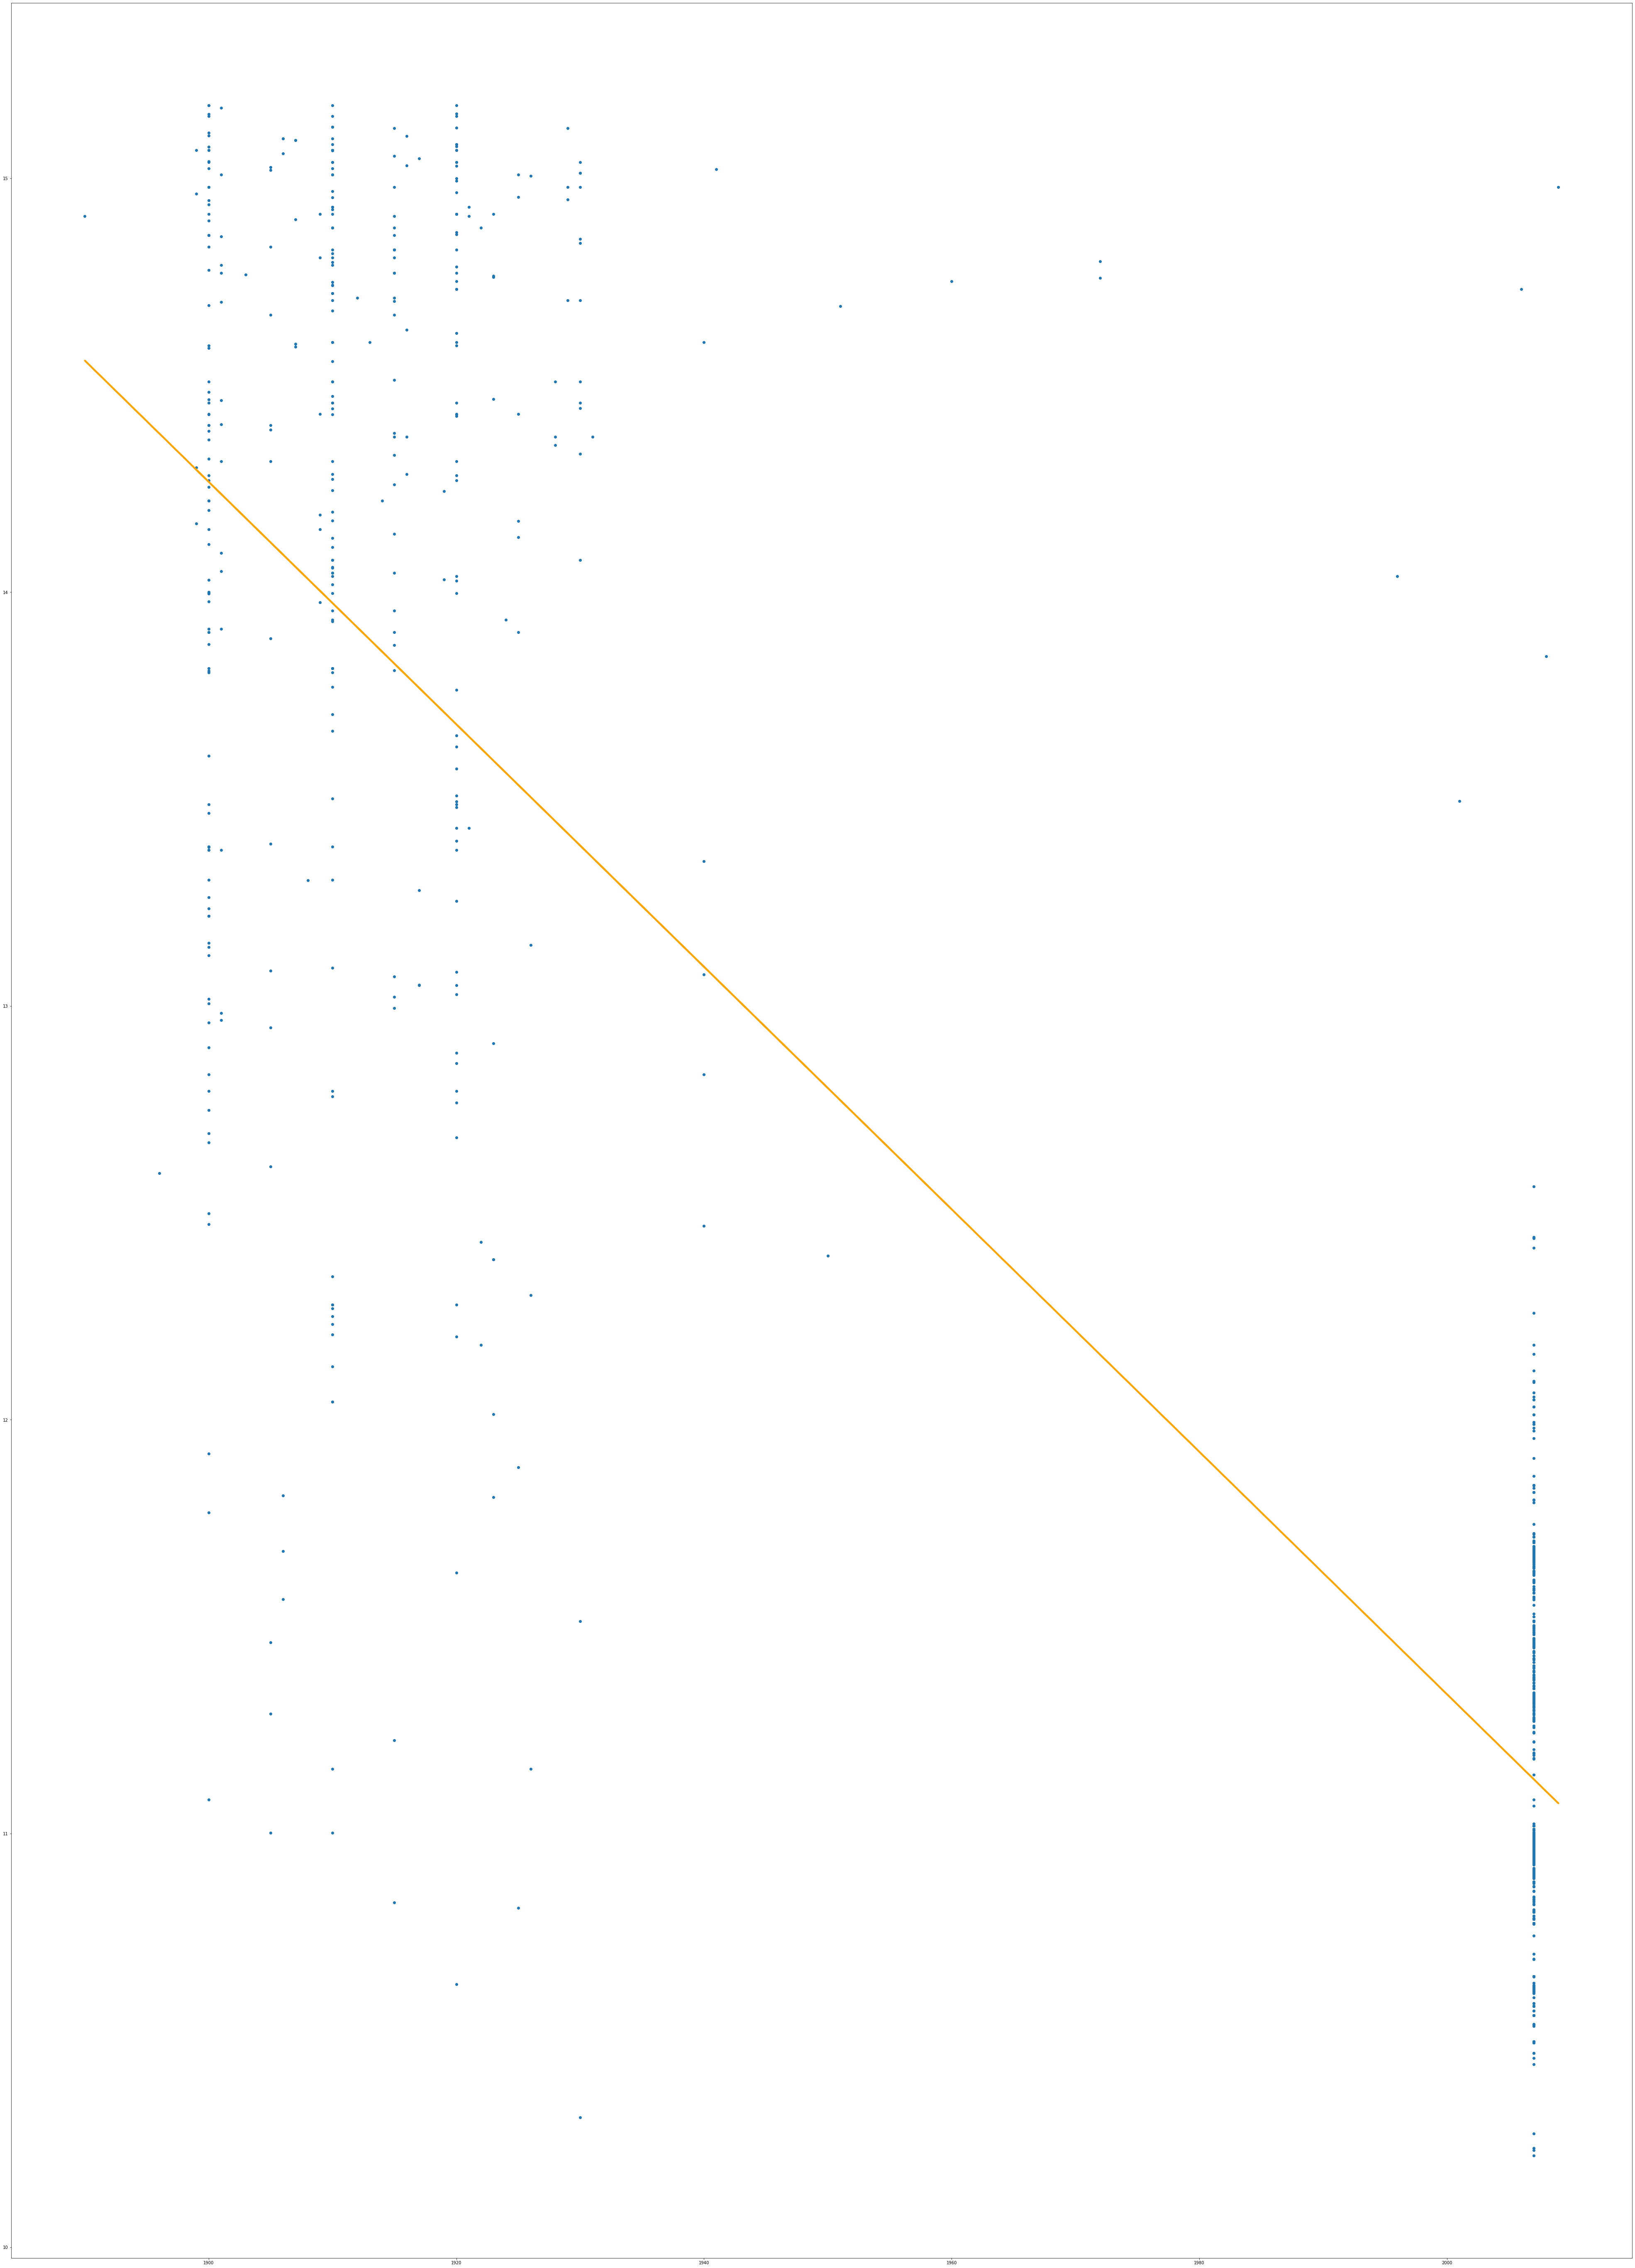

In [25]:
# Create a scatter plot
plt.scatter(x1,y)
# Define the regression equation, so we can plot it later
yhat = -0.0293*x1 + 69.9366
# Plot the regression line against the independent variable (SAT)
fig = plt.plot(x1,yhat, lw=4, c='orange', label ='regression line')
# Label the axes
plt.xlabel('SAT', fontsize = 20)
plt.ylabel('GPA', fontsize = 20)
plt.show()

In [26]:
model = smf.ols(formula='LPRICE ~ RESIDENTIAL_UNITS + YEAR_BUILT + COMMERCIAL_UNITS +  LAND_SQUARE_FEET +\
YEAR_BUILT + GROSS_SQUARE_FEET', data=man_norm).fit()
print(model.params)
print('R squared is: ', model.rsquared)
model.summary()

Intercept            0.726460
RESIDENTIAL_UNITS    0.365408
YEAR_BUILT           0.013554
COMMERCIAL_UNITS     0.576975
LAND_SQUARE_FEET    -0.016655
GROSS_SQUARE_FEET   -0.621154
dtype: float64
R squared is:  0.8392407883932568


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LPRICE   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1044.
Date:                Sun, 22 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:03:29   Log-Likelihood:                 638.79
No. Observations:                1006   AIC:                            -1266.
Df Residuals:                    1000   BIC:                            -1236.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.7265      0.013     54.165      0.000       0.700       0.753
RESIDENTIAL_UNITS     0.3654      0.023     16.099      0.000       0.321       0.410
YEAR_BUILT            0.0136      0.045      0.299      0.765      -0.075       0.103
COMMERCIAL_UNITS      0.5770      0.061      9.434      0.000       0.457       0.697
LAND_SQUARE_FEET     -0.0167      0.040     -0.411      0.681      -0.096       0.063
GROSS_SQUARE_FEET    -0.6212      0.058    -10.788      0.000      -0.734      -0.508
==============================================================================
Omnibus:                      201.266   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              634.579
Skew:                          -0.973   Prob(JB):                    1.60e-138
Kurtosis:                       6.369   Cond. No.                         31.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""